Code adapted from: https://github.com/martingerlach/testing-statistical-laws-in-complex-systems

associated to: 
M. Gerlach and E. G. Altmann, "Testing statistical laws in complex systems", <a href="https://doi.org/10.1103/PhysRevLett.122.168301"> Phys. Rev. Lett. 122, 168301 (2019) </a>

In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.cm as cm
cmap = cm.tab10


In [4]:
## custom packages
src_dir = os.path.join(os.pardir,'src')
sys.path[0] = src_dir

from data_io_ts import *
from stats import xdata_to_xnx, x_autocorr_sm_ext, determine_tau
from powerlaw_fit import *

# import setup for figure layout (see src/modules_plotting.py to customize)
from modules_plotting import * 

# Generate dataset:

We generate synthetic data that follows a power-law:

$p(x) \propto x^{-\gamma }$.

The data is generated using a Markov-process such that we can include correlations via a paramter $\mu$.

For $\mu = 1$, we recover the case of independently sampled data. 

In [140]:

label = 'mcmc_zipf'
k = 10 ## number of neighbors for correlated step
Ntypes = 2*10**5 ## maximum number of symbols
Ntokens = 10**4-1 ## number of samples
alpha = 1.7 ## powerlaw exponent
mu = 0.05 ## correlation parameter
list_mu = [1.0,0.05] ## correlated and uncorrelated case


#correlated
dict_args = {'Ntypes':Ntypes,
             'Ntokens':Ntokens,
             'alpha':alpha,
             'mu':mu,
             'k':k,
             'src_dir':src_dir,
     }
x_data = get_xdata_ts_wrapper(label,dict_args)

#uncorreleated

dict_argsU = {'Ntypes':Ntypes,
             'Ntokens':Ntokens,
             'alpha':alpha,
             'mu':1.0,
             'k':k,
             'src_dir':src_dir,
     }
x_dataU = get_xdata_ts_wrapper(label,dict_argsU)


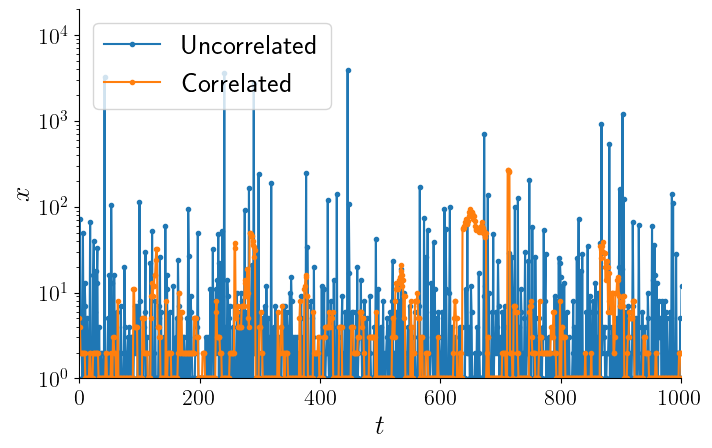

In [142]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)
plt.plot(range(len(x_dataU)),x_dataU,".-",label="Uncorrelated")
plt.plot(range(len(x_data)),x_data,".-",label="Correlated")
plt.xlim(0,1000)
plt.ylim(1,20000)
plt.yscale("log")
plt.xlabel(r"$t$",fontsize=20)
plt.ylabel(r"$x$",fontsize=20)
plt.legend(loc=2,fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("fig/synthetic1.png",dpi=300,bbox_inches='tight')

plt.show()

# Plot the distribution and the fit

In [144]:
## Empirical distribution
xmin = 1
xmax = Ntypes
x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

N = np.sum(nx)
px = nx/N
Fx = 1-np.cumsum(px)

## Fit: powerlaw

result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax)
alphaH = result['alpha']
px_fit = pdf_power_disc(x,xmin,xmax,alphaH)
Fx_fit = cdf_power_disc(x,xmin,xmax,alphaH)

Text(0.6, 0.6, '$\\propto x^{-\\gamma}$')

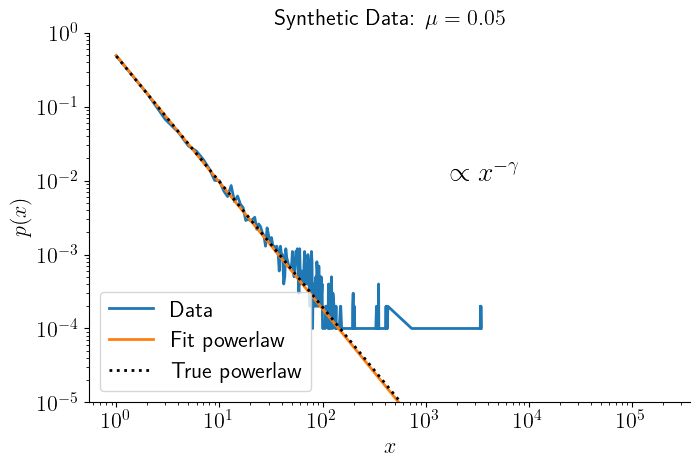

In [145]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

## Plot the distribution
x_ = x
y_ = px

c_ = cmap(0)
ax.plot(x_,y_,marker='o',ms=0,lw=2,c = c_,label = 'Data')

## Plot the fit
c_ = cmap(1)
x_ = x
y_ = px_fit
plt.plot(x_,y_,lw=2,c=c_, label = 'Fit powerlaw')

## Plot the truth
c_ = 'black'
x_ = np.arange(1,Ntypes+1,1)
y_ = x_**(-alpha)
y_ /= np.sum(y_)
plt.plot(x_,y_,lw=2,c=c_, ls=':', label = 'True powerlaw')


## Layout stuff
ax.legend(loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

# ax.set_xlim(1,1000)
ax.set_ylim(10**(-5),1)

ax.set_xlabel(r'$x$')#,labelpad=0)
ax.set_ylabel(r'$p(x)$')
ax.set_title(r'Synthetic Data: $\mu = %s$'%(mu))

x_annot_formula = 0.6
y_annot_formula = 0.6
ax.annotate(r'$\propto x^{-\gamma}$',xy=(x_annot_formula,y_annot_formula),xycoords = 'axes fraction')#,size=8)

# Autocorrelation function

Note that we are taking the $\log x$ to calculate the autocorrelation (this leads to a more conservative estimation of $\tau^*)$.

Note that different realizations can lead to different autocorrelation times.

In [146]:
nrep = 10**3
q1,q2 = 1,99
result = x_autocorr_sm_ext(np.log(x_data),nrep=nrep,q=[q1,q2])
x = result['tau']
y_mu,y_1,y_2 = result['C']
y_mu_rand,y_1_rand,y_2_rand = result['C_rand']

## here we calculate from t=0,1,...,t^* where t^* is the first point
## where true C(t) is within the q-percentiles of the random

# ind_t_star = np.where( (y_mu<=y_2_rand)&(y_mu>=y_1_rand) )[0][1]
ind_t_star = np.where(y_1<=y_2_rand)[0][2]
tau_star = x[ind_t_star]

print('Autocorrelation time: ',tau_star)



Autocorrelation time:  40


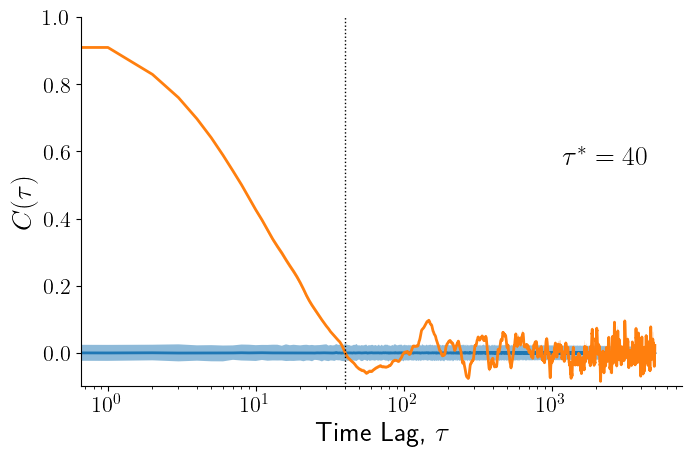

In [147]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

alpha_val = .5

## Plot the randomized autocorrelation
x_ = x
y_ = y_mu_rand
z1_ = y_1_rand
z2_ = y_2_rand
c_ = cmap(0)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Uncorrelated')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)


## Plot the empirical autocorrelation
x_ = x
y_ = y_mu
z1_ = y_1
z2_ = y_2
c_ = cmap(1)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Correlated')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)


ax.plot([tau_star,tau_star],[-1,1],lw=1,color='black',ls=':')


## Layout stuff
#ax.legend(loc='upper right',fontsize=25)

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel(r'Time Lag, $\tau$',fontsize=20)#,labelpad=0)
ax.set_ylabel(r'$C(\tau)$',fontsize=20)
ax.set_ylim(-0.1,1.)


x_annot_tau = 0.8
y_annot_tau = 0.6
ax.annotate(r'$\tau^*=%s$'%(int(tau_star)),xy=(x_annot_tau,y_annot_tau),xycoords = 'axes fraction')
ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig("fig/synthetic2.png",dpi=300,bbox_inches='tight')


# Subsampling the data

### p-value for the original dataset

In [16]:
nrep_synth = 100 ## number of synthetic datasets to generate for empirical p-value

x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax,nrep_synth=nrep_synth)

alpha = result['alpha'] ## fitted parameter alpha
pval = result['pval'] ## p-value
KS = result['KS'] ## KS-distance

print('Original dataset. N = %s'%(N))
print('Empirical p-value from %s synthetic datasets: '%(nrep_synth), pval)

Original dataset. N = 10000
Empirical p-value from 100 synthetic datasets:  0.0


### p-value from subsampled dataset

Note that the subsampling generates different datasets each time; therefore there will be variability in the measured p-value

In [17]:
p_sub = 1./tau_star ## 0 ... 1 (keep nothing ... keep all); we set 1/tau_star
N_sub = int(p_sub*N)
nrep_synth = 100 ## number of synthetic datasets to generate for empirical p-value


## subsample -- take N_sub samples from x_data without replacement
x_data_sub = np.random.choice(x_data,size=N_sub,replace=False)
x,nx = xdata_to_xnx(x_data_sub,norm=False,xmin=xmin,xmax=xmax)
result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax,nrep_synth=nrep_synth)

alpha = result['alpha'] ## fitted parameter alpha
pval = result['pval'] ## p-value
KS = result['KS'] ## KS-distance

print(r'Subsampled dataset: n = %s (n/N ~ %s)'%(N_sub,p_sub)) 
print('Empirical p-value from %s synthetic datasets: '%(nrep_synth), pval)

Subsampled dataset: n = 200 (n/N ~ 0.02)
Empirical p-value from 100 synthetic datasets:  0.8200000000000001


# Compare correlated and uncorrelated data

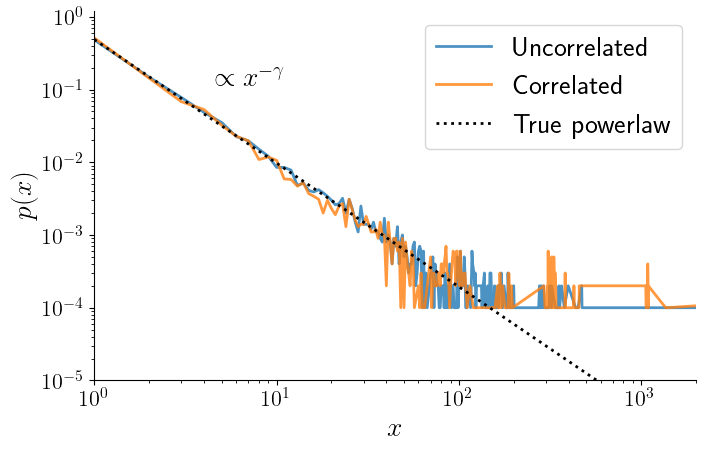

In [148]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)


for i_mu , mu in enumerate(list_mu):
    dict_args = {'Ntypes':Ntypes,
             'Ntokens':Ntokens,
             'alpha':alpha,
             'mu':mu,
             'k':k,
             'src_dir':src_dir,
     }
    x_data = get_xdata_ts_wrapper(label,dict_args)
    xmin = 1
    xmax = Ntypes
    x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

    N = np.sum(nx)
    px = nx/N
    
    

    ## Plot the distribution
    x_ = x
    y_ = px

    c_ = cmap(i_mu)
    if mu == 1.:
        l_ = 'Uncorrelated'
    else:
        l_ = 'Correlated'
    ax.plot(x_,y_,marker='o',ms=0,lw=2,c = c_,label = l_,alpha=0.8)

## Plot the truth
c_ = 'black'
x_ = np.arange(1,Ntypes+1,1)
y_ = x_**(-alpha)
y_ /= np.sum(y_)
plt.plot(x_,y_,lw=2,c=c_, ls=':', label = 'True powerlaw')


## Layout stuff
ax.legend(loc='upper right',fontsize=20)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1,2000)
ax.set_ylim(10**(-5),1.2)

ax.set_xlabel(r'$x$',fontsize=20)#,labelpad=0)
ax.set_ylabel(r'$p(x)$',fontsize=20)

x_annot_formula = 0.2
y_annot_formula = 0.8
ax.annotate(r'$\propto x^{-\gamma}$',xy=(x_annot_formula,y_annot_formula),xycoords = 'axes fraction')#,size=8)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig("fig/synthetic3.png",dpi=300,bbox_inches='tight')

# As a function of datasize

### KS- distance

### fitted exponent $\hat{\alpha}$

We generate synthetic datasets of different length.

We fit a powerlaw and get the KS-distance and the powerlaw-exponent.

Note this could take a while to run. 

In [10]:
n = 30 # number of realizations; in the paper we choose n = 100



#label = 'mcmc_zipf'
#k = 5 ## number of neighbors for correlated step
#Ntypes = 10**3 ## maximum number of symbols
# Ntokens = 10**5 ## number of samples
#alpha = 1.5 ## powerlaw exponent


## vary Ntokens
n_Nmax = 15
n_Nmin=5
list_Ntokens = np.logspace(n_Nmin,n_Nmax,n_Nmax-n_Nmin+1,base=2).astype('int')
Nmax = list_Ntokens[-1]

xmin = 1
xmax = Ntypes

In [8]:
alpha

1.7

In [9]:
arr_KS = np.zeros(( n, len(list_Ntokens),len(list_mu) ))
arr_alpha = np.zeros(( n, len(list_Ntokens),len(list_mu) ))
for i_mu , mu in enumerate(list_mu):
    for i_n in range(n):
        dict_args = {'Ntypes':Ntypes,
                     'Ntokens':Nmax,
                     'alpha':alpha,
                     'mu':mu,
                     'k':k,
                      'src_dir':src_dir,
                 }
        x_data = get_xdata_ts_wrapper(label,dict_args)
        for i_Ntokens,Ntokens in enumerate(list_Ntokens):
            x_data_tmp = x_data[:Ntokens]
            x,nx = xdata_to_xnx(x_data_tmp,norm=False,xmin=xmin,xmax=xmax)
            result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax)
            alphaH = result['alpha']
            KS = result['KS']
            arr_KS[i_n,i_Ntokens,i_mu] = KS
            arr_alpha[i_n,i_Ntokens,i_mu] = alphaH

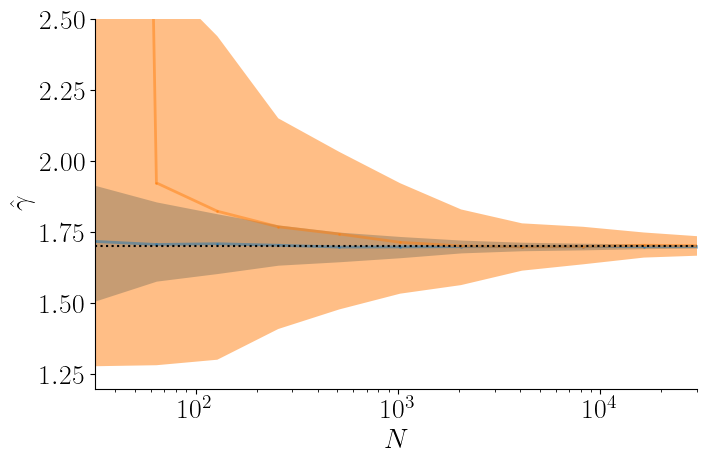

In [149]:
alpha_val=0.5
## plot the fitted exponent
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

# ax_in.set_xticklabels([])
for i_mu,mu in enumerate(list_mu):
   
    x_ = list_Ntokens
    Z = arr_alpha[:,:,i_mu]
    y_ = np.mean(Z,axis=0)
    y1_,y2_ = np.percentile(Z,q=[5,95],axis=0)
    c_ = cmap(i_mu)
    if mu == 1.:
        l_ = 'Uncorrelated'
    else:
        l_ = 'Correlated'
    ax.plot(x_,y_,marker='o',ms=1,lw=lw,c = c_,label=l_,alpha=alpha_val)
    ax.fill_between(x_,y1_,y2_,color=c_,alpha=0.5,lw=0)

ax.plot(x_,alpha+0.0*x_,ls=':',color='black')

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xticks([10**2,10**3,10**4,10**5,10**6])
ax.set_ylim(1,2)

ax.set_xlabel(r'$N$',fontsize=20)
ax.set_ylabel(r'$\hat{\gamma}$',fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
#ax.legend(fontsize=25)
plt.ylim(1.2,2.5)
plt.xlim(32,30000)
plt.savefig("fig/synthetic4.png",dpi=300,bbox_inches='tight')

# As a function of datasize

### KS- distance

### fitted exponent $\hat{\alpha}$

We generate synthetic datasets of different length.

We fit a powerlaw and get the KS-distance and the powerlaw-exponent.

Note this could take a while to run. 

In [122]:
n = 100 # number of realizations; in the paper we choose n = 100


In [123]:
arr_KS = np.zeros(( n, len(list_Ntokens),len(list_mu) ))
arr_alpha = np.zeros(( n, len(list_Ntokens),len(list_mu) ))
for i_mu , mu in enumerate(list_mu):
    for i_n in range(n):
        dict_args = {'Ntypes':Ntypes,
                     'Ntokens':Nmax,
                     'alpha':alpha,
                     'mu':mu,
                     'k':k,
                      'src_dir':src_dir,
                 }
        x_data = get_xdata_ts_wrapper(label,dict_args)
        for i_Ntokens,Ntokens in enumerate(list_Ntokens):
            x_data_tmp = x_data[:Ntokens]
            x,nx = xdata_to_xnx(x_data_tmp,norm=False,xmin=xmin,xmax=xmax)
            result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax)
            alphaH = result['alpha']
            KS = result['KS']
            arr_KS[i_n,i_Ntokens,i_mu] = KS
            arr_alpha[i_n,i_Ntokens,i_mu] = alphaH

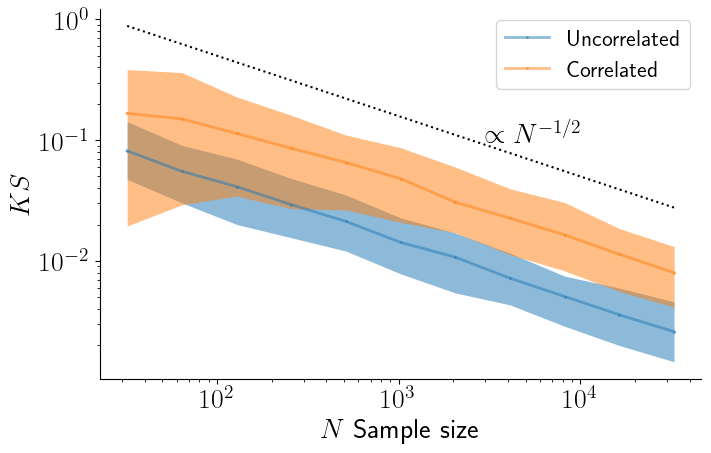

In [176]:
alpha_val=0.5
## plot the KS-distance
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

# ax_in.set_xticklabels([])
for i_mu,mu in enumerate(list_mu):
   
    x_ = list_Ntokens
    Z = arr_KS[:,:,i_mu]
    y_ = np.mean(Z,axis=0)
    y1_,y2_ = np.percentile(Z,q=[5,95],axis=0)
    c_ = cmap(i_mu)
    if mu == 1.:
        l_ = 'Uncorrelated'
    else:
        l_ = 'Correlated'
    ax.plot(x_,y_,marker='o',ms=1,lw=lw,c = c_,label=l_,alpha=alpha_val)
    ax.fill_between(x_,y1_,y2_,color=c_,alpha=0.5,lw=0)

ax.plot(x_,5*x_**(-0.5),ls=':',color='black')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10**2,10**3,10**4])
# ax.set_ylim(0.5*10**(-4),10**0)

ax.set_xlabel(r'$N$ Sample size',fontsize=20)
ax.set_ylabel(r'$KS$',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.legend()

ax.annotate(r'$\propto N^{-1/2}$',xy=(0.64,0.64),xycoords = 'axes fraction')
plt.savefig("fig/synthetic5.png",dpi=300,bbox_inches='tight')

In [125]:
# choice of N=1024
list_Ntokens[6]

2048

0.03062779432216803

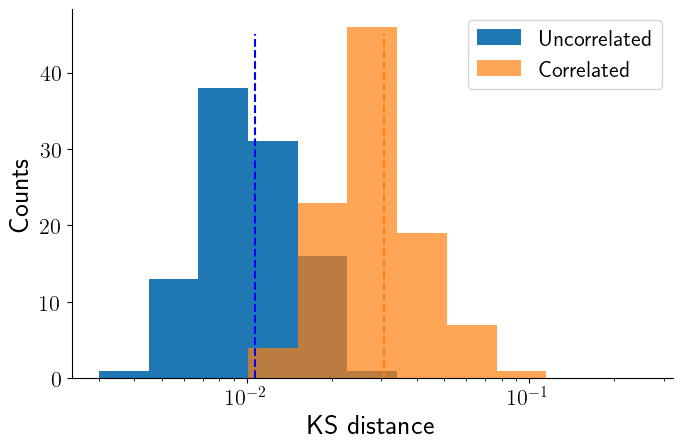

In [177]:
nindex=6
bs=np.power(1.5,np.arange(12)+1)*0.002

plt.hist(arr_KS[:,nindex,0],bins=bs,label="Uncorrelated")
plt.hist(arr_KS[:,nindex,1],alpha=0.7,bins=bs,label="Correlated")
plt.plot([np.mean(arr_KS[:,nindex,1]),np.mean(arr_KS[:,nindex,1])],[0,45],"--",color=c_)
plt.plot([np.mean(arr_KS[:,nindex,0]),np.mean(arr_KS[:,nindex,0])],[0,45],"--",color="blue")
plt.xscale("log")
plt.xlabel("KS distance",fontsize=20)
plt.ylabel("Counts",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=16)
plt.savefig("fig/synthetic6.png",dpi=300,bbox_inches='tight')
plt.show()

# Distribution of p-values

We generate n_rep synthetic datasets. We fit each dataset according to the standard procedure and obtain an empirical p-value (based on n_rep_synth comparisons of independently drawn data using the fitted exponent).

Since the null hypothesis is true (data comes from the powerlaw), we should obtain an approximately flat distribution of p-values.

- for the original data, we get a peak at 0
- for the decorrelated (subsampled) data, we get an approximately flat distribution


Note, that this will probably take a while to run.


In [171]:
n_rep = 100 # number of realizations; in the paper we choose n = 100
n_rep_synth = 100 ## number of datasets for calculating the empirical p-value in each realization
n_rep_auto = 100


In [172]:
list_pval = []
list_pval_sub = []

for i_n_rep in range(n_rep):
    ## draw the data
    x_data = get_xdata_ts_wrapper(label,dict_args)
    
    ## fit the data to get a p-value
    x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)
    result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax,
                                     nrep_synth=n_rep_synth)
    pval = result['pval']
    list_pval += [pval]
    
    ## estimate correlation and subsample
    tau = determine_tau(x_data,nrep=n_rep_auto)
    N_sub = int(Ntokens/tau)
    x_data_sub = np.random.choice(x_data,size = N_sub, replace=False)
    ## fit the subsampled data to get a p-value
    x,nx = xdata_to_xnx(x_data_sub,norm=False,xmin=xmin,xmax=xmax)
    result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax,
                                     nrep_synth=n_rep_synth)
    pval = result['pval']
    list_pval_sub += [pval]
    

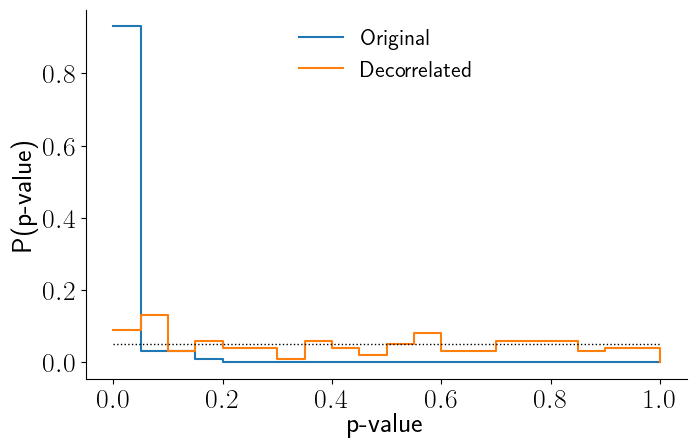

In [178]:
bins = np.linspace(0.0,1.0,21)

## plot the fitted exponent
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

## correlated
H,edges = np.histogram(list_pval,bins=bins)
H = np.append(H,0)
H = H/float(n_rep)
ax.step(edges,H,where='post',label='Original' )

## de-correlated
H,edges = np.histogram(list_pval_sub,bins=bins)
H = np.append(H,0)
H = H/float(n_rep)
ax.step(edges,H,where='post',label='Decorrelated' )
ax.tick_params(axis='both', which='major', labelsize=20)

ax.plot([0.,1],[1/(len(bins)-1),1/(len(bins)-1)],lw=1,ls=':',color='black')

ax.legend(loc='upper center',frameon=False,fontsize=16)
ax.set_ylabel('P(p-value)',fontsize=20)
ax.set_xlabel('p-value',labelpad=0,fontsize=20)
plt.savefig("fig/synthetic7.png",dpi=300,bbox_inches='tight')